In [210]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
from collections import namedtuple
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    if type(N) is tuple:
        params.set_size_inches((plSize[0]*N[0], plSize[1]*N[1]))
    else:
        params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

In [5]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [6]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [7]:
df_contigs_size = pd.read_csv(data_folder + 'contig_metadata_patric_genomes', sep='\t', 
                        names=['genome_id', 'contig', 'size'], 
                         dtype={'genome_id': str, 'size': int}).set_index('genome_id')
df_contigs_size.head()

,contig,size
genome_id,,
100053.4,JQGS01000001,2023
100053.4,JQGS01000002,25623
100053.4,JQGS01000003,11202
100053.4,JQGS01000004,109309
100053.4,JQGS01000005,13452


In [8]:
df_genome_info = pd.read_csv(data_folder + 'genome_info', sep='\t',
                            names=['genome_id', 'name'],
                            dtype={'genome_id': str}).set_index('genome_id')
df_genome_info.head()

,name
genome_id,
100053.4,Leptospira alexanderi strain 56650
100053.5,Leptospira alexanderi strain 56643
100053.6,Leptospira alexanderi strain 56640
100053.7,Leptospira alexanderi strain 56159
100053.8,Leptospira alexanderi strain 56659


In [9]:
df_phages = pd.read_csv(data_folder + 'phages.coords.tsv', sep='\t',
                       names=['genome_id', 'contig', 'phage_group', 's', 'e', 'gene_start', 'gene_end'],
                       dtype={'genome_id': str}).set_index('genome_id')
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5.0,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6.0,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2.0,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2.0,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3.0,2250.0,51967.0,2.0,58.0


In [386]:
df_arrays = pd.read_csv(data_folder + 'spacers.info.tsv', sep='\t',
                       names=['genome_id', 'contig', 'array_id', 's', 'e', 'ori', 'size', 'type', 'conf', 'repeat'], 
                       dtype={'genome_id': str}).set_index('genome_id')
df_arrays.head()

,contig,array_id,s,e,ori,size,type,conf,repeat
genome_id,,,,,,,,,
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NaN,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NaN,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NaN,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NaN,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NaN,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


In [10]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna.hits'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


### Remove uninteresting duplicates

In [11]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

In [12]:
# Remove double arrays (same seq, same hit, same array location)
df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

# SET GENOME

In [1299]:
genome = "907.4"  # Priming (CAS-TypeIC/F)
genome = "1049978.3"  # Phage and more (CAS-TypeIE)
genome = "1049982.3"  # Everywhere (CAS-TypeIE)
genome = "1071918.3"  # Everywhere (CAS-TypeIIC)
genome = "1121114.4"  # Phage (CAS-TypeIC)
genome = "1121370.3"  # All in phage (CAS-TypeIE)
genome = "1121910.3"  # Phage and outside (CAS-TypeIF)
genome = "1121910.4"  # In phage (CAS-TypeIF)
genome = "1196095.186"  # !! Gene clustered !! (CAS-TypeIF)
genome = "1218600.3"  # Everywhere (CAS-TypeIE)
genome = "1223544.3"  # All in phage (CAS-TypeIE)
genome = "1310619.3"  # Mostly in phage (CAS-TypeIF)
genome = "1314.299"  # In phage and outside (CAS-TypeIC)
genome = "1334.46"  # In phages (CAS-TypeIC/IIA)
genome = "1341639.3"  # In phages (CAS-TypeIF)
genome = "1384589.3"  # In phages (CAS-TypeIE)
genome = "1477.15"  # In phages (CAS-TypeIC)
genome = "1496.1488"  # In phages (CAS-TypeIB)
genome = "1496.2099"  # In phages (CAS-TypeIB)
genome = "1507806.28"  # In phages (CAS-TypeIB)
genome = "1531.4"  # In phages (CAS-TypeIC)
genome = "1564506.4"  # In phages (CAS)
genome = "1581116.3"  # In phages (CAS-TypeIE)
genome = "1657.3"  # In phages (CAS-TypeIE)
genome = "1768.22"  # In phages (CAS-TypeIU)
genome = "1795832.3"  # In phages (CAS-TypeIC)
genome = "1941207.3"  # In phages and outside (NOCAS)
genome = "1965578.3"  # In a phage (CAS-TypeIC)
genome = "287.1029"  # A cluster in a region with a lot of unclassified genes (perhaps phage region missed by virsorter) (CAS-TypeIF)
genome = "294671.3"  # All phage (TypeIIIA/IB)
genome = "31973.4"  # Phage and everywhere (CAS-TypeIB)
genome = "379597.3"  # In phage (CAS-TypeIF)
genome = "386891.25"  # In phage (TypeVA, TypeIC, TypeIIIB)
genome = "39482.3"  # Interesting hotspots ??!! (TypeIC (2x), TypeIII?)
genome = "525268.3"  # All in a phage (CAS-TypeIE)
genome = "64187.137"  # In phage and a bit around (CAS-TypeIC)
genome = "64187.148"  # In phage and outside (CAS-TypeIC)
genome = "64187.210"  # In phage and outside (CAS-TypeIC)
genome = "64187.219"  # In phage and outside (CAS-TypeIC)
genome = "756272.5"  # All in phage (CAS-TypeIC)
genome = "837.101"  # Mostly in phage (CAS-TypeVIB1/CAS
# genome = ""?


if False:
    from subprocess import run
    for genome in genomes:
        run(('scp "alive.bio.uu.nl:/hosts/linuxhome/mgx/DB/PATRIC/patricdb-201*/%s.fna" /home/hielke/bep/genomes' 
             % genome).split())

In [1300]:
ident = 90
dfa = df.loc[genome].query('hit_ident > @ident')
# dfa

In [1301]:
dfa = dfa.assign(orientation = 0 > dfa['c_1'] - dfa['c_2'])  # True: forwards // False: backwards

In [1302]:
genome

'837.101'

In [1303]:
df_contigs_size.head()

,contig,size
genome_id,,
100053.4,JQGS01000001,2023
100053.4,JQGS01000002,25623
100053.4,JQGS01000003,11202
100053.4,JQGS01000004,109309
100053.4,JQGS01000005,13452


In [1304]:
dfa_contigs_size = df_contigs_size.reset_index().query('genome_id == @genome') \
    .pipe(
        lambda d: d.assign(
            cumsum=np.concatenate((
                [0], 
                d['size'].cumsum().values[1:]
            ))
        )
    ).set_index('contig')

start_dict = {k.replace(".", "_"): v for k, v in dfa_contigs_size['cumsum'].to_dict().items()}
len_dict = {k.replace(".", "_"): v for k, v in dfa_contigs_size['size'].to_dict().items()}

In [1305]:
dfa = dfa.pipe(lambda d:
         d.assign(
             start_genome = d.apply(
                 lambda x: (int(x['c_1']) + int(start_dict[x['contig_hit']])), axis=1
             )
        )
)

In [1306]:
from operator import itemgetter
max_contig, start_max = max(start_dict.items(), key=itemgetter(1))
max_length = start_max + len_dict[max_contig]
print(start_max)
print(max_length)

2290524
2296497


In [1307]:
dfa_phages = df_phages.loc[[genome]]

In [1308]:
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5.0,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6.0,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2.0,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2.0,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3.0,2250.0,51967.0,2.0,58.0


In [1309]:
virsorter_coords

genome_id
756272.5    (1291657.0, 1369989.0)
756272.5    (1718629.0, 1749905.0)
756272.5      (238921.0, 284859.0)
dtype: object

In [1310]:
dfa_phages

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
837.101,FUFJ01000025,3.0,116.0,10811.0,1.0,13.0
837.101,FUFJ01000056,3.0,1410.0,32470.0,2.0,36.0


In [1311]:
virsorter_coords = dfa_phages.apply(lambda x: 
                                    (start_dict[x['contig']] + x['s'], start_dict[x['contig']] + x['e']) # partial contig
                                    if not pd.isnull(x['s']) else
                                    (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']])
                                    , axis=1)  # full contig
virsorter_coords

genome_id
837.101      (639861.0, 650556.0)
837.101    (1516593.0, 1547653.0)
dtype: object

In [1312]:
# dfvg = dfv.query('genome == @genome')
# virsorter_coords = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]) if x['range'] is np.nan else 
#                print("banaan"), axis=1)
#           (start_dict[x['contig']] + int(x['range'].split('-')[0]), start_dict[x['contig']] + int(x['range'].split('-')[1])), axis=1)
# A = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]), axis=1)


In [1313]:
total_len = dfa_contigs_size.iloc[-1]['size'] + dfa_contigs_size.iloc[-1]['cumsum']
dfa_phages = dfa_phages.assign(size=dfa_phages['e'] - dfa_phages['s'])
total_vir = dfa_phages['size'].sum()
print("%.2f %% of the genome is phage DNA" % ((total_vir / total_len) * 100))
print("%.2f %% of the selfhits are located at phage DNA" % (sum(dfa['with_phage'] == 2) / len(dfa)* 100))

1.82 % of the genome is phage DNA
81.48 % of the selfhits are located at phage DNA


In [1314]:
if False:
    B = set(dfog['spacer'])
    print("$|".join(B))
    print(len(B))

In [1315]:
if False:
    A = {'LFBV01000005_2_3', 'LFBV01000005_2_6', 'LFBV01000010_2_11', 'LFBV01000001_6_1', 'LFBV01000010_1_6', 'LFBV01000013_1_1', 'LFBV01000005_2_5', 'LFBV01000001_8_2', 'LFBV01000001_6_3', 'LFBV01000001_8_4', 'LFBV01000001_8_3', 'LFBV01000001_8_1', 'LFBV01000010_2_6', 'LFBV01000005_2_4', 'LFBV01000005_2_2', 'LFBV01000001_5_3', 'LFBV01000010_5_2', 'LFBV01000001_8_6', 'LFBV01000001_5_1', 'LFBV01000010_1_2', 'LFBV01000001_6_2', 'LFBV01000010_2_5', 'LFBV01000001_7_2', 'LFBV01000001_7_3', 'LFBV01000001_7_4', 'LFBV01000001_7_1', 'LFBV01000001_5_2', 'LFBV01000010_4_13', 'LFBV01000001_8_5'}
    print(B - A)

In [1316]:
if False: dfog.to_csv("hits/" + genome + ".hits.tsv", index=False, sep='\t')

In [1317]:
dfa.sort_values(by=['array_id', 'spacer_pos'])

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,orientation,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
837.101,TCGTTTGAAGCGCGGTGTTGATAGCGCCTATCAGC,9741,9775,FUFJ01000056,1,FUFJ01000075_1_1,100.0000,35,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA+,FUFJ01000056_12,UNCLASSIFIED,0.000000,leader,True,1524924
837.101,AAAATCCGCTCTTCGGACTCATAAAGGCAAAGTTTAA,2461,2497,FUFJ01000025,2,FUFJ01000075_1_2,94.5900,37,15331,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA-,FUFJ01000025_6,UNKNOWN,0.050000,middle,True,642206
837.101,TTGGTCGGGCCTGCGCCCTTGCGCGTATAGATGCTGA,11464,11500,FUFJ01000056,3,FUFJ01000075_1_3,100.0000,37,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA+,FUFJ01000056_13,UNKNOWN,0.100000,middle,True,1526647
837.101,TTCATCTGCGTGCGTTTCGCTTCCACCCATGCGTT,26254,26288,FUFJ01000056,4,FUFJ01000075_1_4,94.2900,35,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA+,FUFJ01000056_28,UNKNOWN,0.150000,middle,True,1541437
837.101,CAGATACCGACGCACTTCGTCGATGCTGCTCGCA,2797,2830,FUFJ01000025,5,FUFJ01000075_1_5,100.0000,34,15331,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA-,FUFJ01000025_7,UNCLASSIFIED,0.200000,middle,True,642542
837.101,GTCGATTGTGCTCGCTCAAGTATTCGTATATCTTC,806,775,FUFJ01000056,13,FUFJ01000075_1_13,91.4286,35,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,1,RNA+,FUFJ01000056_1,Phage integrase SAM-like domain,0.600000,middle,False,1515989
837.101,TAAGGACTACCTCGCCAACCTCCGCGCGCAAACGCG,17648,17613,FUFJ01000056,14,FUFJ01000075_1_14,97.2200,36,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA-,FUFJ01000056_15,Short C-terminal domain,0.650000,middle,False,1532831
837.101,CGTCATCACTTGACGTAGTTTCGTGAGAATTTCGT,19643,19677,FUFJ01000056,18,FUFJ01000075_1_18,91.4300,35,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA+,FUFJ01000056_19,UNKNOWN,0.850000,middle,True,1534826
837.101,ATCAGTACGATCTGCAGGAGCTGGAGATACAGACGCT,15630,15594,FUFJ01000056,19,FUFJ01000075_1_19,91.8900,37,32471,FUFJ01000075_1,21,6.26,30,NA,CAS,-1,NULL,NULL,3,2,RNA-,FUFJ01000056_15,Short C-terminal domain,0.900000,middle,False,1530813


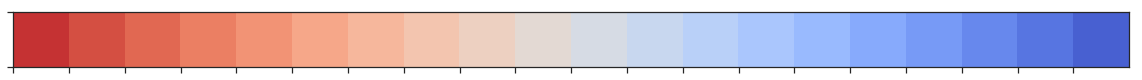

In [1318]:
sns.palplot(sns.color_palette("coolwarm", 20)[::-1])
# sns.diverging_palette(20, 220, n=array_size,)

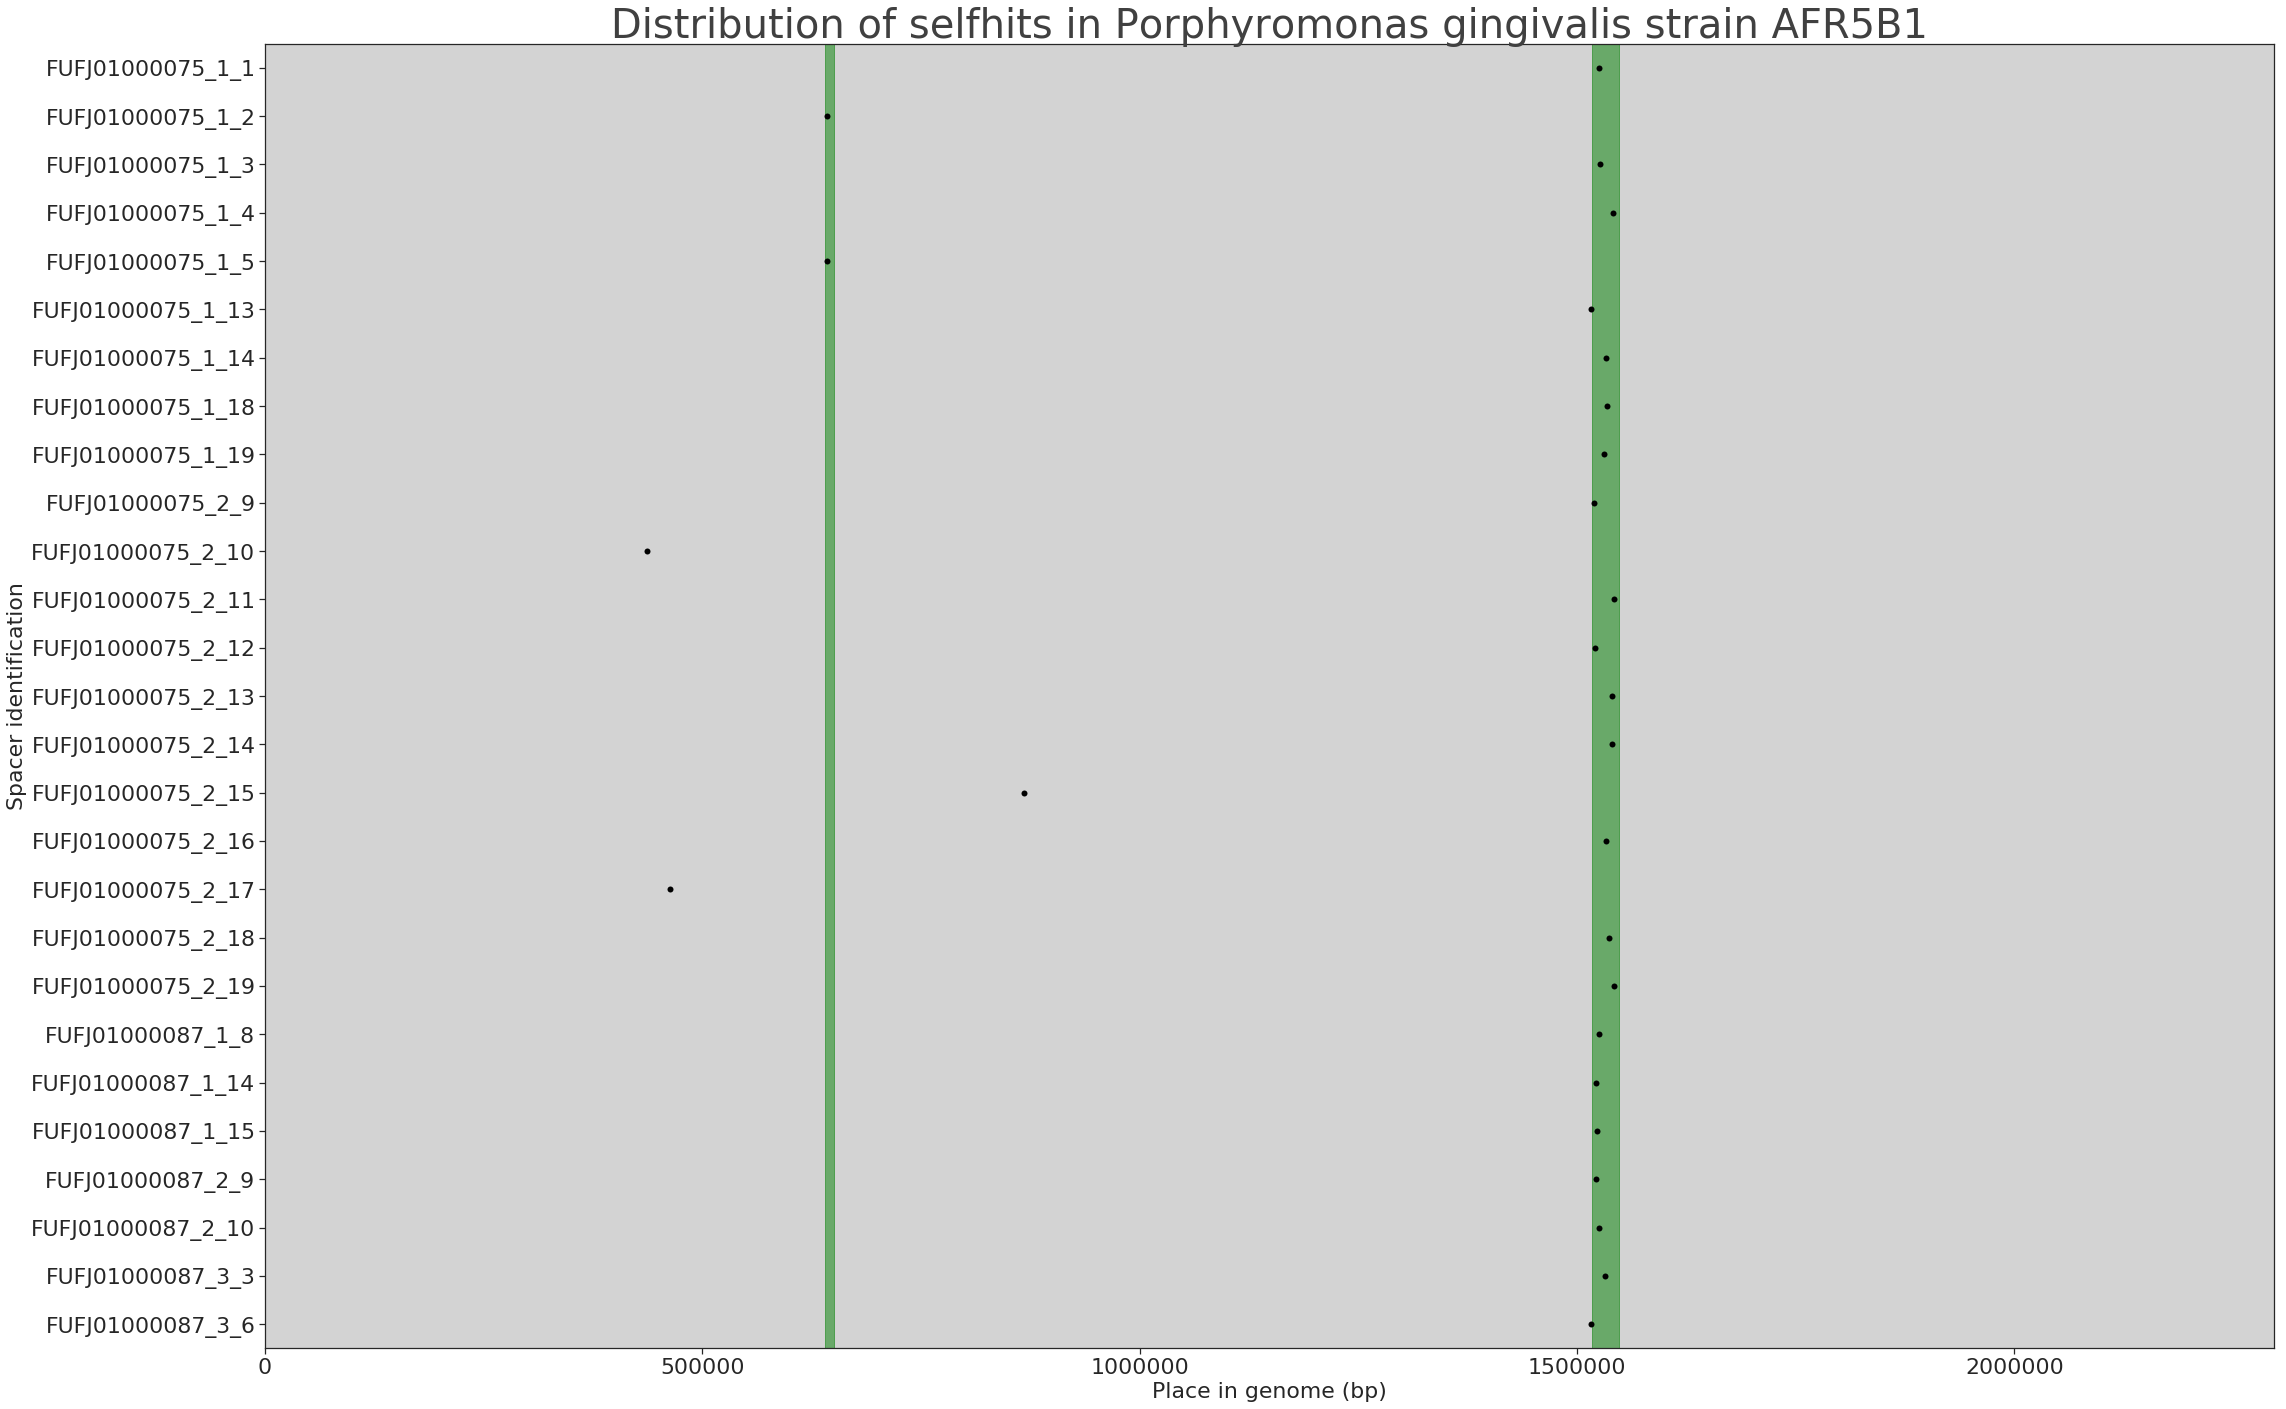

In [1319]:
# plt.style.use('ggplot')
if True:
    ax = sns.stripplot(data=dfa.sort_values(by=['array_id', 'spacer_pos']), 
                       x='start_genome', jitter=0, size=6, y='spacer_id', 
                       palette=['black'])
    increase_size_by(6, 22, plt)
    # import matplotlib.transforms as mtransforms
    # trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for span in virsorter_coords:
        ax.axvspan(span[0], span[1], alpha=.5, color='green')
    # plt.savefig("place_of_hits_" + genome + ".png", format='png', bbox_inches='tight')
    plt.xlim((1, max_length))
    plt.title("Distribution of selfhits in %s" % df_genome_info.loc[genome]['name'], size=40)
    plt.xlabel("Place in genome (bp)")
    plt.ylabel("Spacer identification")
    # plt.savefig("/home/hielke/bep/jups/bep_figs/%s.png" % genome, format='png', bbox_inches='tight')

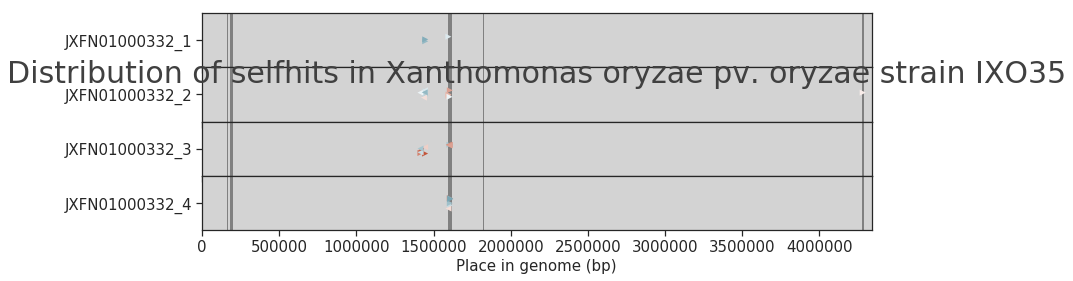

In [1235]:
from collections import namedtuple
Genome = namedtuple("Genome", ['id', 'name', 'max_length'])

# rc['axes.facecolor'] = (.15, .15, .15, .3)
rc['axes.facecolor'] = 'lightgray'
sns.set(rc=rc)

class HitPlotter:

    
    def __init__(self, dfa, dfa_arrays, y, hue, arrays_num, genome_info, palette=None):
        self.dfa = dfa
        self.dfa_arrays = dfa_arrays
        self.y = y
        self.hue = hue
        self.arrays_num = arrays_num
        self.fig_size = (arrays_num, 1)
        self.fig, self.axes = plt.subplots(*self.fig_size, sharex=True)
        self.axes = self.axes if hasattr(self.axes, '__getitem__') else [self.axes]
        self.cur_plot = 0
        self.palette = palette or (lambda array_size: sns.diverging_palette(20, 220, n=array_size,))
        self.genome_info = genome_info

        
    def plot_orientation(self, data, palette, ax):
        from functools import partial
        plot_hits = partial(
                    sns.stripplot, 
                    ax=ax, 
                    x='start_genome', 
                    jitter=True, size=6, 
                    y=self.y, hue=self.hue, )
        
        forward_spacer_pos_palette = [palette[getattr(i, self.hue)] 
                                      for i in data.itertuples(index=False)
                                      if i.orientation]
        backward_spacer_pos_palette = [palette[getattr(i, self.hue)] 
                                      for i in data.itertuples(index=False)
                                      if not i.orientation]
        # Forward
        if any(data.orientation):
            plot_hits(data=data[data.orientation], marker='>', palette=forward_spacer_pos_palette)
        # Backward
        if not all(data.orientation):
            plot_hits(data=data[~data.orientation], marker='<', palette=backward_spacer_pos_palette)
    
    
    def plot_on_fig(self, array_name, array_size, ax):
        spacer_pos_palette = [0] + self.palette(array_size)
        self.plot_orientation(self.dfa.query('%s == @array_name' % self.y).sort_values(by=self.hue),
                              spacer_pos_palette, ax)
    
    
    def plot_array(self, array_name, array_size):
        self.plot_on_fig(array_name, array_size, self.axes[self.cur_plot])
        self.cur_plot += 1
        
    
    def plot_all_arrays(self):
        plot_names = []
        for array_tuple in ([namedtuple("Row", self.dfa_arrays.index)(*self.dfa_arrays)] 
                     if type(self.dfa_arrays) is pd.Series 
                     else self.dfa_arrays.itertuples(index=False)):
            if array_tuple.array_id not in self.dfa['array_id'].values:
                continue

            plot_names.append(array_tuple.array_id)
            self.plot_array(array_tuple.array_id, array_tuple.size)
        
        return plot_names
        
        
        
    def add_virsorter(self, virsorter_coords):
        for span in virsorter_coords:
            for ax in self.axes:
                ax.axvspan(span[0], span[1], alpha=1, color='gray')
        
    
    def figure_cleanup(self, title_adjustment=2.6):
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.xlim((1, self.genome_info.max_length))
        increase_figsize((2, 1))
        for ind, ax in enumerate(self.axes):
            ax.set_ylabel("")
            ax.get_legend().remove()
            
        plt.title("Distribution of selfhits in %s" % self.genome_info.name, size=30, y=title_adjustment)
        plt.xlabel("Place in genome (bp)")
        
        

if genome in ["1121910.3", "1314.299", "287.1029", "64187.137", "64187.148"]:
    # The only CRISPR array that is confirmed, does not have selfhits. 
    
    dfa_arrays = df_arrays.loc[genome]
    y = 'array_id'
    hue = 'spacer_pos'
    genome_info = Genome(id=genome, name=df_genome_info.loc[genome]['name'], max_length=max_length)
    
    palette = lambda array_size: sns.color_palette("coolwarm", array_size)[::-1]
    palette = lambda array_size: sns.diverging_palette(20, 220, n=array_size,)
    
    plotter = HitPlotter(dfa=dfa, dfa_arrays=dfa_arrays, y=y, hue=hue, 
                         arrays_num=len(dfa['array_id'].unique()), palette=palette,
                         genome_info=genome_info, )
    
    plotter.plot_all_arrays()
                
    plotter.add_virsorter(virsorter_coords)
    plotter.figure_cleanup()

    
if genome == "907.4":
    # Specific plot for this genome:
    # CRISPR Detect splits the arrays incorrectly: 1-3 (Forward), 4-6 (Forward), 7-9 (Reverse), 10-13 (Reverse) 
    # are single arrays 
    # based on adjacency and equal CRISPR repeat.
    # 
    # There are self-hits in 4-6 (Forward) and 10-13 (Reverse)
    # The size of these are:
    # 4: 22
    # 5: 8
    # 6: 4
    #
    # 10: 2
    # 11: 21
    # 12: 22
    # 13: 6
    #
    # Cumulative (NB 10-13 is Reverse)
    #
    # 4: 0
    # 5: 22
    # 6: 30
    # (size: 34)
    #
    # 10: 49
    # 11: 28
    # 12: 6
    # 13: 0
    # (size: 51)
    actual_spacer_pos_start = {
        4: 0, 
        5: 22, 
        6: 30, 
        10: 49,
        11: 28, 
        12: 6,
        13: 0,
    }
    dfa = dfa.pipe(lambda d:
             d.assign(
             array=np.where(
                 d['array_id'].str.len() == 12, "Reversed_array", "Forwards_array"),
             actual_spacer_pos=
                  d['array_id'].str.split('_').str.get(-1).astype(int).apply(actual_spacer_pos_start.get)
                  + d['spacer_pos'])
    )
    
    y = 'array'
    hue = 'actual_spacer_pos'
    arrays_num = 2
    plot_names = ["Reversed_array", "Forwards_array"]
    genome_info = Genome(id=genome, name=df_genome_info.loc[genome]['name'], max_length=max_length)
    
    # Plotting
    palette = lambda array_size: sns.color_palette("coolwarm", array_size)[::-1]
    palette = lambda array_size: sns.diverging_palette(20, 220, n=array_size,)
    
    plotter = HitPlotter(dfa=dfa, dfa_arrays=dfa_arrays, y=y, hue=hue, 
                         arrays_num=arrays_num, palette=palette,
                         genome_info=genome_info)

    
    plotter.plot_array(plot_names[0], 51)
    plotter.plot_array(plot_names[1], 34)
    
    plotter.add_virsorter(virsorter_coords)
    plotter.figure_cleanup(title_adjustment=2.6)

In [979]:
all(dfa[dfa.array_id == array_tuple.array_id].orientation)

True

In [ ]:
dfa.columns

In [974]:
data

NameError: name 'data' is not defined

In [982]:
all([0, 0])

False